<a href="https://colab.research.google.com/github/LxYuan0420/nlp/blob/main/notebooks/Topic_Modeling_with_Quantized_LLMs_(OpenHermes_2_5_Mistral_7B_GGUF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modeling with Quantized LLMs**
*Create easily interpretable topics with BERTopic and LLMs*
<br>

<img src="https://pbs.twimg.com/media/GDA2JQoX0AElWoq?format=jpg&name=large">


---
        
💡 **NOTE**: We will want to use a GPU to run both 7B LLMs as well as BERTopic for this use case. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---

We will start by installing a number of packages that we are going to use throughout this example:

In [1]:
%%capture
# BERTopic + llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python
!pip install bertopic datasets

# DataMapPlot
!git clone https://github.com/TutteInstitute/datamapplot.git
!pip install datamapplot/.

# GPU-accelerated HDBSCAN + UMAP
!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64

# 📄 **Data**

We are going to apply topic modeling on a number of ArXiv abstracts. They are a great source for topic modeling since they contain a wide variety of topics and are generally well-written.

In [1]:
from datasets import load_dataset

# ArXiv ML Documents
docs = load_dataset("CShorten/ML-ArXiv-Papers")["train"]["abstract"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# 🦙 **Quantized LLM**

To use a quantized LLMs, we make use of the `GGUF` format together with `llama-cpp-python`. When you access any of [TheBloke's quantized models](https://huggingface.co/TheBloke), you can click on files and find specific quantized formats. We are going with a 4-bit quantized model:

In [2]:
!wget https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
# !wget https://huggingface.co/TheBloke/dolphin-2.7-mixtral-8x7b-GGUF/resolve/main/dolphin-2.7-mixtral-8x7b.Q3_K_M.gguf

--2024-01-05 04:34:30--  https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
Resolving huggingface.co (huggingface.co)... 13.33.33.110, 13.33.33.20, 13.33.33.102, ...
Connecting to huggingface.co (huggingface.co)|13.33.33.110|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/65/3b/653b1cc7a4558cd22c0ac02df471105878a080cb5694622ccd566697c574592f/cd58120326971c71c0590f6b7084a0744e287ce9c67275d8b4bf34a5947d950b?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27openhermes-2.5-mistral-7b.Q4_K_M.gguf%3B+filename%3D%22openhermes-2.5-mistral-7b.Q4_K_M.gguf%22%3B&Expires=1704685567&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwNDY4NTU2N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzY1LzNiLzY1M2IxY2M3YTQ1NThjZDIyYzBhYzAyZGY0NzExMDU4NzhhMDgwY2I1Njk0NjIyY2NkNTY2Njk3YzU3NDU5MmYv

Next, we load the model using `llama-cpp-python`:

In [3]:
from llama_cpp import Llama

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path="openhermes-2.5-mistral-7b.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"], max_tokens=1024)

AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 1 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


Test prompting the LLM

In [4]:
output = llm("Q: Name the planets in the solar system? A: ")

In [5]:
output

{'id': 'cmpl-5ddf1393-1d3c-4c47-807b-1d49934f8476',
 'object': 'text_completion',
 'created': 1704429294,
 'model': 'openhermes-2.5-mistral-7b.Q4_K_M.gguf',
 'choices': [{'text': '1. Mercury, 2. Venus, 3. Earth,',
   'index': 0,
   'logprobs': None,
   'finish_reason': 'length'}],
 'usage': {'prompt_tokens': 14, 'completion_tokens': 16, 'total_tokens': 30}}

In [6]:
output = llm(
    "Q: Name the planets in the solar system? A: ",
    max_tokens=1024, # default 16
    stop=["Q:", "\n"] # this is important otherwise the model keeps generating unrelated texts
)
output

Llama.generate: prefix-match hit


{'id': 'cmpl-00848ed8-3dd9-4efe-91f1-efdce6d02fde',
 'object': 'text_completion',
 'created': 1704429304,
 'model': 'openhermes-2.5-mistral-7b.Q4_K_M.gguf',
 'choices': [{'text': '1. Mercury, 2. Venus, 3. Earth, 4. Mars, 5. Jupiter, 6. Saturn, 7. Uranus, 8. Neptune.',
   'index': 0,
   'logprobs': None,
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 14, 'completion_tokens': 48, 'total_tokens': 62}}

In [7]:
print(output["choices"][0]["text"])

1. Mercury, 2. Venus, 3. Earth, 4. Mars, 5. Jupiter, 6. Saturn, 7. Uranus, 8. Neptune.


We pass the LLM to BERTopic with a custom prompt. Let's add `KeyBERTInspired` representations to compare the LLM representations with:

In [8]:
from bertopic.representation import KeyBERTInspired, LlamaCPP

prompt = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt),
}

# 🗨️ **BERTopic**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [9]:
from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
# from umap import UMAP
# from hdbscan import HDBSCAN

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

Batches:   0%|          | 0/3675 [00:00<?, ?it/s]

In [10]:
# Define sub-models
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=400, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [11]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2024-01-05 04:50:28,017 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-05 04:50:36,333 - BERTopic - Dimensionality - Completed ✓
2024-01-05 04:50:36,346 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-05 04:50:50,390 - BERTopic - Cluster - Completed ✓
2024-01-05 04:50:50,428 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 37/37 [10:13<00:00, 16.57s/it]
2024-01-05 05:01:41,296 - BERTopic - Representation - Completed ✓


Now that we are done training our model, let's see what topics were generated:

In [12]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,-1,63953,-1_the_of_and_to,"[the, of, and, to, in, we, is, for, that, on]","[models, model, accuracy, datasets, algorithms...",[Out-of-Distribution Detection in Deep Learnin...,[ The Expectation-Maximization (EM) algorithm...
1,0,7060,0_policy_reinforcement_learning_the,"[policy, reinforcement, learning, the, to, rl,...","[reinforcement, dynamics, learning, robot, tra...",[Reinforcement Learning Exploration and Genera...,[ The $Q$-function is a central quantity in m...
2,1,5721,1_and_the_of_to,"[and, the, of, to, in, for, medical, data, is,...","[mri, convolutional, segmentation, imaging, ne...","[Medical Image Segmentation., , , , , , , , , ]","[ With the arrival of the big data era, more ..."
3,2,4644,2_language_the_and_of,"[language, the, and, of, to, we, text, in, on,...","[nlp, embeddings, embedding, semantic, languag...",[Language Models and Vision-and-Language Learn...,[ While recent research on natural language i...
4,3,2849,3_speech_audio_speaker_the,"[speech, audio, speaker, the, to, and, of, in,...","[voice, speech, language, trained, models, mod...","[""Deep Learning Speech Processing Techniques"",...",[ Domain mismatch between training and testin...
5,4,2795,4_privacy_federated_fl_data,"[privacy, federated, fl, data, the, learning, ...","[federated, distributed, algorithms, datasets,...","[Privacy in Federated Learning Systems., , , ,...",[ Federated learning (FL) has emerged as a pr...
6,5,2279,5_graph_node_graphs_the,"[graph, node, graphs, the, nodes, of, gnns, an...","[graphs, subgraph, embeddings, graph, embeddin...","[Graph Representation Learning, , , , , , , , , ]",[ Recent advances in representation learning ...
7,6,1986,6_adversarial_attacks_robustness_attack,"[adversarial, attacks, robustness, attack, exa...","[adversarial, adversarially, dnns, dnn, attack...",[Adversarial Attacks and Robustness in Deep Le...,[ Deep neural networks are vulnerable to adve...
8,7,1809,7_matrix_the_rank_of,"[matrix, the, rank, of, we, is, in, and, tenso...","[matrices, factorization, matrix, sparse, regu...","[Matrix Approximation Methods, , , , , , , , , ]","[ In this work, we propose a new randomized a..."
9,8,1788,8_regret_bandit_the_algorithm,"[regret, bandit, the, algorithm, we, of, onlin...","[bandits, algorithms, optimization, stochastic...","[Regret Bound Algorithms for Bandit Problems, ...",[ Online learning algorithms are designed to ...


# 📊 Visualization with DataMapPlot

In [13]:
import PIL
import numpy as np
import requests

# Prepare logo
bertopic_logo_response = requests.get(
    "https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png",
    stream=True,
    headers={'User-Agent': 'My User Agent 1.0'}
)
bertopic_logo = np.asarray(PIL.Image.open(bertopic_logo_response.raw))

We can use the labels created by the LLM and assign them to topics that we have created:

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `openhermes-2.5-mistral-7b`'}>)

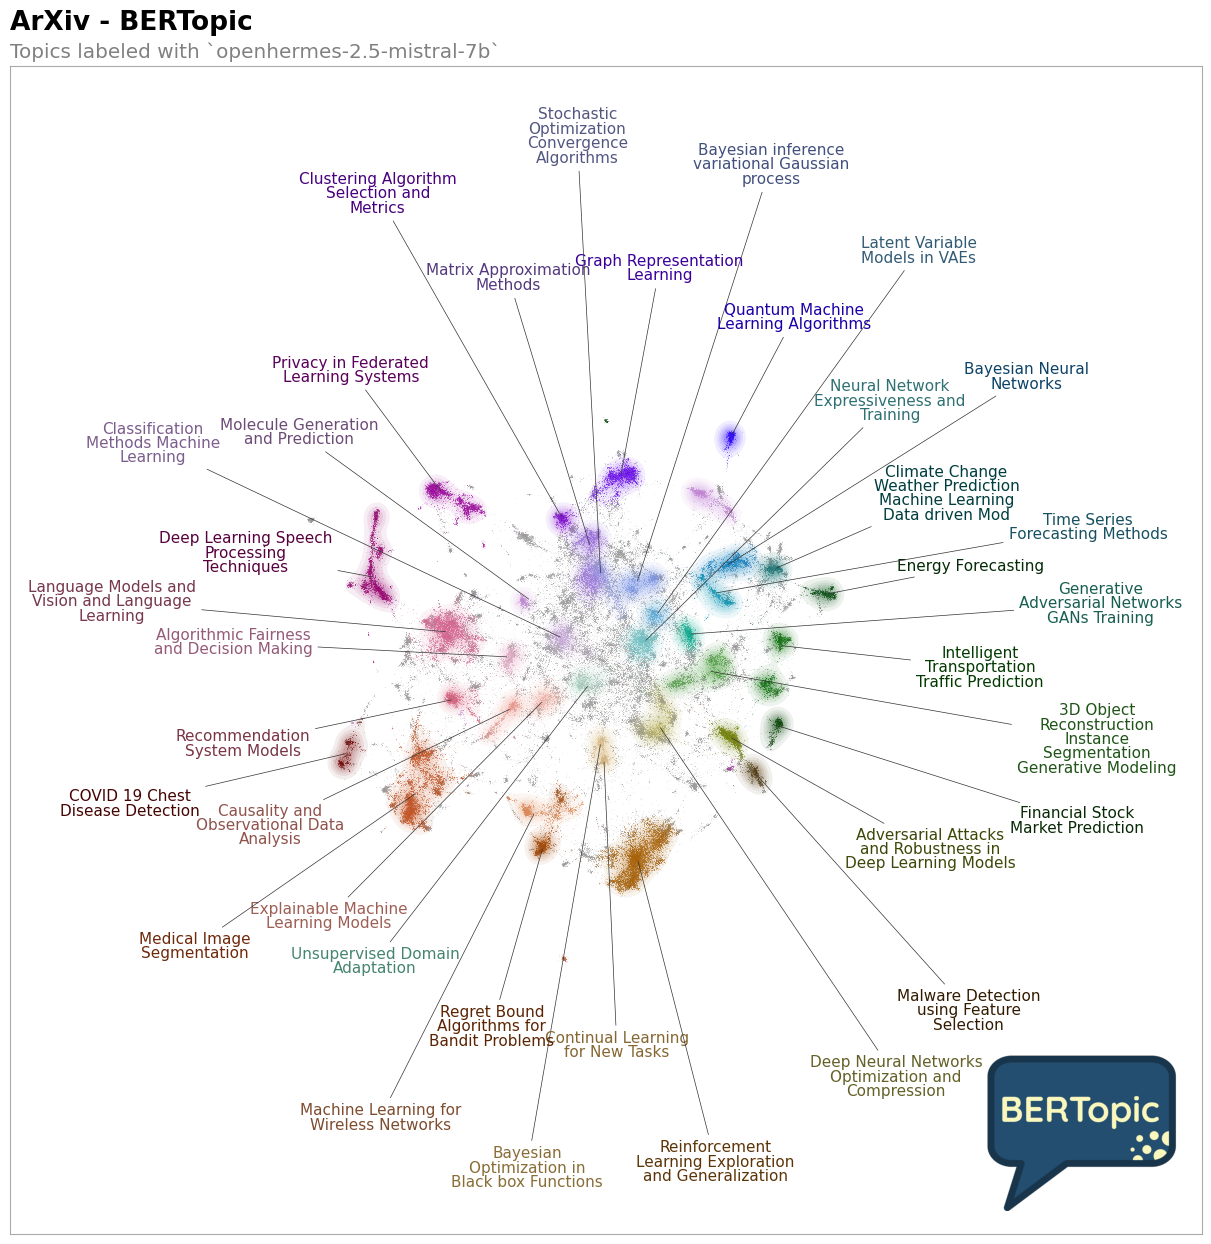

In [14]:
import datamapplot
import re

# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

# Run the visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=11,
    title="ArXiv - BERTopic",
    sub_title="Topics labeled with `openhermes-2.5-mistral-7b`",
    label_wrap_width=20,
    use_medoids=True,
    logo=bertopic_logo,
    logo_width=0.16
)

Additional: Testing `OpenHermes-2.5-Mistral-7B-GGUF`

In [17]:
output = llm(
      "Personally I like criminal and funny themes. Could you recommend me some 5 to watch? And provide one liner summary for each movie", # Prompt
      max_tokens=1024, # Generate up to 32 tokens
      stop=["Q:"], # Stop generating just before the model would generate a new question
      echo=False # Echo the prompt back in the output
) # Generate a completion, can also call create_completion


Llama.generate: prefix-match hit


In [18]:
print(output["choices"][0]["text"])

?

1. The Grand Budapest Hotel (2014)
One Liner Summary: A concierge at a famous European hotel becomes entwined in a murder mystery involving a valuable painting and a vengeful bellboy.

2. The Nice Guys (2016)
One Liner Summary: In 1970s Los Angeles, a mismatched private detective and his stoner assistant investigate the disappearance of a fallen porn starlet.

3. In Bruges (2008)
One Liner Summary: Two hitmen on the lam hide out in the beautiful Belgian city of Bruges after botching their latest job.

4. The Big Lebowski (1998)
One Liner Summary: A slacker and avid bowler named Jeff “The Dude” Lebowski is mistaken for a millionaire with the same name, which sets off a crazy chain of events involving nihilists, kidnappers, and pornographers.

5. Hot Fuzz (2007)
One Liner Summary: A top London cop is transferred to a sleepy village with a dark secret in this action-packed spoof of police procedural dramas.
